In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import json
from os.path import expanduser
import sqlite3
import seaborn as sns
import random
from cmcrameri import cm
from matplotlib import colors
import matplotlib.patches as patches
import glob
import alphatims.bruker

### detections

In [2]:
experiment_name = 'P3856'
run_name = 'P3856_YHE211_1_Slot1-1_1_5104'

EXPERIMENT_DIR = '/media/big-ssd/experiments/{}'.format(experiment_name)

FEATURES_PASEF_DIR = '{}/features-pasef'.format(EXPERIMENT_DIR)
FEATURES_PASEF_FILE = '{}/exp-{}-run-{}-features-pasef-dedup.feather'.format(FEATURES_PASEF_DIR, experiment_name, run_name)

minvi = 5000
FEATURES_3DID_DIR = sorted(glob.glob('/media/big-ssd/results-P3856-3did/minvi-{}-*/features-3did'.format(minvi)))[-1]
FEATURES_3DID_FILE = '{}/exp-{}-run-{}-features-3did-dedup.feather'.format(FEATURES_3DID_DIR, experiment_name, run_name)

FEATURES_MQ_DIR = '{}/features-mq'.format(EXPERIMENT_DIR)
FEATURES_MQ_FILE = '{}/exp-{}-run-{}-features-mq-dedup.pkl'.format(FEATURES_MQ_DIR, experiment_name, run_name)

In [3]:
MAXIMUM_Q_VALUE = 0.01

In [4]:
# only look at this part of the run
RT_LOWER = 1650
RT_UPPER = 2200

In [5]:
# define a straight line to exclude the charge-1 cloud
def scan_coords_for_single_charge_region(mz_lower, mz_upper):
    scan_for_mz_lower = max(int(-1 * ((1.2 * mz_lower) - 1252)), 0)
    scan_for_mz_upper = max(int(-1 * ((1.2 * mz_upper) - 1252)), 0)
    return {'scan_for_mz_lower':scan_for_mz_lower, 'scan_for_mz_upper':scan_for_mz_upper}

#### PASEF-seeded

In [6]:
# load the features detected by PASEF
features_pasef_df = pd.read_feather(FEATURES_PASEF_FILE)

In [7]:
features_pasef_df['excluded'] = features_pasef_df.apply(lambda row: row.scan_lower < scan_coords_for_single_charge_region(row.monoisotopic_mz, row.monoisotopic_mz)['scan_for_mz_lower'], axis=1)
features_pasef_df = features_pasef_df[(features_pasef_df.excluded == False)]
features_pasef_df = features_pasef_df[(features_pasef_df.rt_lower >= RT_LOWER) & (features_pasef_df.rt_upper <= RT_UPPER)]

#### 3DID

In [8]:
# load the features detected by 3DID
features_3did_df = pd.read_feather(FEATURES_3DID_FILE)

#### MaxQuant

In [9]:
# load the features detected by MaxQuant
with open(FEATURES_MQ_FILE, 'rb') as handle:
    d = pickle.load(handle)
features_mq_df = d['features_df']

In [10]:
features_mq_df.sample(n=5)

,feature_id,monoisotopic_mass,charge,monoisotopic_mz,intensity,scan_apex,scan_lower,scan_upper,rt_apex,rt_lower,rt_upper,raw_file,envelope,isotope_count,mq_index,ms2_peaks
8752,1196589,1665.7908,2,833.90270,126200,438,414.0,462.0,2160.0,2157.090,2162.910,P3856_YHE211_1_Slot1-1_1_5104,"[[833.9027, 0.0], [836.4110875, 0.0]]",5,8752,"[{'mz': 205.10431, 'intensity': 8}, {'mz': 211..."
13371,1209581,1865.9511,2,933.98283,53219,240,202.5,277.5,2034.0,2031.618,2036.382,P3856_YHE211_1_Slot1-1_1_5104,"[[933.98283, 0.0], [935.98954, 0.0]]",4,13371,"[{'mz': 223.07427, 'intensity': 10}, {'mz': 25..."
21488,1225451,2576.2582,3,859.76002,66556,669,645.0,693.0,2130.0,2128.149,2131.851,P3856_YHE211_1_Slot1-1_1_5104,"[[859.76002, 0.0], [861.4322783333334, 0.0]]",5,21488,"[{'mz': 211.14945, 'intensity': 9}, {'mz': 218..."
18364,1219905,2135.8423,2,1068.92840,71095,294,268.5,319.5,1644.0,1640.310,1647.690,P3856_YHE211_1_Slot1-1_1_5104,"[[1068.9284, 0.0], [1070.9351100000001, 0.0]]",4,18364,"[{'mz': 234.1421, 'intensity': 30}, {'mz': 250..."
5686,1188990,1520.7380,2,761.37627,96176,519,480.0,558.0,1896.0,1893.090,1898.910,P3856_YHE211_1_Slot1-1_1_5104,"[[761.37627, 0.0], [763.38298, 0.0]]",4,5686,"[{'mz': 203.06557, 'intensity': 11}, {'mz': 20..."


In [11]:
features_mq_df['excluded'] = features_mq_df.apply(lambda row: row.scan_lower < scan_coords_for_single_charge_region(row.monoisotopic_mz, row.monoisotopic_mz)['scan_for_mz_lower'], axis=1)
features_mq_df = features_mq_df[(features_mq_df.excluded == False)]
features_mq_df = features_mq_df[(features_mq_df.rt_lower >= RT_LOWER) & (features_mq_df.rt_upper <= RT_UPPER)]
features_mq_df = features_mq_df[(features_mq_df.isotope_count >= 3)]

In [12]:
print('{} features from PASEF, {} features from MaxQuant, {} features from 3DID'.format(len(features_pasef_df), len(features_mq_df), len(features_3did_df)))


208899 features from PASEF, 15044 features from MaxQuant, 32333 features from 3DID


#### consolidate the features from all methods

In [13]:
combined_names = ['feature_id','charge','monoisotopic_mz','scan_apex','rt_apex']

In [14]:
combined_features_mq_df = features_mq_df[combined_names].copy()
combined_features_mq_df['method'] = 'mq'

combined_features_pasef_df = features_pasef_df[combined_names].copy()
combined_features_pasef_df['method'] = 'pasef'

combined_features_3did_df = features_3did_df[combined_names].copy()
combined_features_3did_df['method'] = '3did'

combined_features_df = pd.concat([combined_features_mq_df,combined_features_pasef_df,combined_features_3did_df], axis=0, sort=False, ignore_index=True)
combined_features_df['method_feature_id'] = combined_features_df.method+'-'+combined_features_df.feature_id.astype('str')

#### find the features in common

In [15]:
DUP_MZ_TOLERANCE_PPM = 10
DUP_SCAN_TOLERANCE = 20
DUP_RT_TOLERANCE = 5

In [16]:
# set up dup definitions
MZ_TOLERANCE_PERCENT = DUP_MZ_TOLERANCE_PPM * 10**-4
combined_features_df['dup_mz'] = combined_features_df['monoisotopic_mz']  # shorthand to reduce verbosity
combined_features_df['dup_mz_ppm_tolerance'] = combined_features_df.dup_mz * MZ_TOLERANCE_PERCENT / 100
combined_features_df['dup_mz_lower'] = combined_features_df.dup_mz - combined_features_df.dup_mz_ppm_tolerance
combined_features_df['dup_mz_upper'] = combined_features_df.dup_mz + combined_features_df.dup_mz_ppm_tolerance
combined_features_df['dup_scan_lower'] = combined_features_df.scan_apex - DUP_SCAN_TOLERANCE
combined_features_df['dup_scan_upper'] = combined_features_df.scan_apex + DUP_SCAN_TOLERANCE
combined_features_df['dup_rt_lower'] = combined_features_df.rt_apex - DUP_RT_TOLERANCE
combined_features_df['dup_rt_upper'] = combined_features_df.rt_apex + DUP_RT_TOLERANCE

In [17]:
combined_id = 1
sets_d = {'mq':set(), '3did':set(), 'pasef':set()}
features_processed = set()
for row in combined_features_df.itertuples():
    if row.method_feature_id not in features_processed:
        df = combined_features_df[(row.charge == combined_features_df.charge) & (row.dup_mz >= combined_features_df.dup_mz_lower) & (row.dup_mz <= combined_features_df.dup_mz_upper) & (row.scan_apex >= combined_features_df.dup_scan_lower) & (row.scan_apex <= combined_features_df.dup_scan_upper) & (row.rt_apex >= combined_features_df.dup_rt_lower) & (row.rt_apex <= combined_features_df.dup_rt_upper)].copy()
        if len(df) > 0:
            # remove the features that have already been processed
            feature_ids_not_processed = set(df.method_feature_id.tolist()) - features_processed
            df = df[(df.method_feature_id.isin(feature_ids_not_processed))]
            for method in df.method.tolist():
                sets_d[method].add(combined_id)
            # record the features that have been processed
            features_processed.update(set(df.method_feature_id.tolist()))
            combined_id += 1

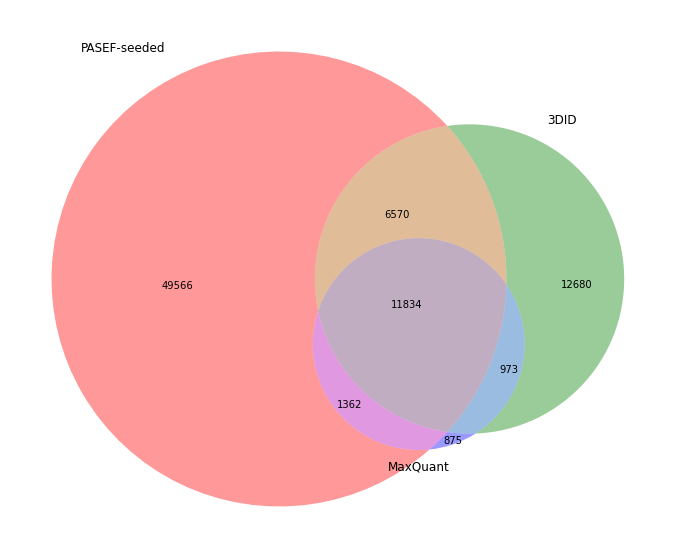

In [18]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

f, ax1 = plt.subplots()
f.set_figheight(10)
f.set_figwidth(15)

plt.margins(0.06)
# plt.title('features detected')

venn3([sets_d['pasef'],sets_d['3did'],sets_d['mq']], ('PASEF-seeded','3DID','MaxQuant'))

plt.show()

### identifications

#### PASEF-seeded

In [19]:
IDENTS_PASEF_DIR = '{}/identifications-pasef'.format(EXPERIMENT_DIR)
IDENTS_PASEF_FILE = '{}/exp-{}-identifications-pasef-recalibrated.feather'.format(IDENTS_PASEF_DIR, experiment_name)

In [20]:
# load the features identified by PASEF
idents_pasef_df = pd.read_feather(IDENTS_PASEF_FILE)
idents_pasef_df = idents_pasef_df[(idents_pasef_df.run_name == run_name) & (idents_pasef_df['percolator q-value'] <= MAXIMUM_Q_VALUE)].copy()

In [21]:
idents_pasef_df['excluded'] = idents_pasef_df.apply(lambda row: row.scan_apex < scan_coords_for_single_charge_region(row.monoisotopic_mz, row.monoisotopic_mz)['scan_for_mz_lower'], axis=1)
idents_pasef_df = idents_pasef_df[(idents_pasef_df.excluded == False)]

In [22]:
idents_pasef_df.reset_index(drop=True).to_feather('{}/idents_pasef_df.feather'.format(expanduser('~')))

#### MaxQuant

In [23]:
MQ_PERCOLATOR_OUTPUT_DIR = '{}/percolator-output-pasef-maxquant'.format(EXPERIMENT_DIR)

In [24]:
# load the percolator output
MQ_PERCOLATOR_OUTPUT_FILE_NAME = "{}/{}.percolator.target.psms.txt".format(MQ_PERCOLATOR_OUTPUT_DIR, experiment_name)
mq_psms_df = pd.read_csv(MQ_PERCOLATOR_OUTPUT_FILE_NAME, sep='\t')
mq_psms_df.rename(columns={'scan': 'mq_index'}, inplace=True)
mq_psms_df.drop(['charge'], axis=1, inplace=True)
# remove the poor quality identifications
mq_psms_df = mq_psms_df[mq_psms_df['peptide mass'] > 0]

In [25]:
idents_mq_df = pd.merge(features_mq_df, mq_psms_df, how='left', left_on=['mq_index'], right_on=['mq_index'])
# remove any features that were not identified
idents_mq_df.dropna(subset=['sequence'], inplace=True)

In [26]:
idents_mq_df = idents_mq_df[(idents_mq_df.raw_file == run_name) & (idents_mq_df['percolator q-value'] <= MAXIMUM_Q_VALUE)].copy()

In [27]:
idents_mq_df['excluded'] = idents_mq_df.apply(lambda row: row.scan_apex < scan_coords_for_single_charge_region(row.monoisotopic_mz, row.monoisotopic_mz)['scan_for_mz_lower'], axis=1)
idents_mq_df = idents_mq_df[(idents_mq_df.excluded == False)]
idents_mq_df = idents_mq_df[(idents_mq_df.rt_apex >= RT_LOWER) & (idents_mq_df.rt_apex <= RT_UPPER)]
idents_mq_df['feature_intensity'] = idents_mq_df.intensity
idents_mq_df = idents_mq_df[(idents_mq_df.isotope_count >= 3)].copy()

In [28]:
idents_mq_df.reset_index(drop=True).to_feather('{}/idents_mq_df.feather'.format(expanduser('~')))

#### consolidate the identifications from all methods

In [29]:
combined_names = ['feature_id','charge','monoisotopic_mz','scan_apex','rt_apex']

In [30]:
combined_idents_mq_df = idents_mq_df[combined_names].copy()
combined_idents_mq_df['method'] = 'mq'

combined_idents_pasef_df = idents_pasef_df[combined_names].copy()
combined_idents_pasef_df['method'] = 'pasef'

combined_idents_3did_df = features_3did_df[combined_names].copy()
combined_idents_3did_df['method'] = '3did'

combined_idents_df = pd.concat([combined_idents_mq_df,combined_idents_pasef_df,combined_idents_3did_df], axis=0, sort=False, ignore_index=True)
combined_idents_df['method_feature_id'] = combined_idents_df.method+'-'+combined_idents_df.feature_id.astype('str')

#### find the identifications in common

In [31]:
# set up dup definitions
MZ_TOLERANCE_PERCENT = DUP_MZ_TOLERANCE_PPM * 10**-4
combined_idents_df['dup_mz'] = combined_idents_df['monoisotopic_mz']  # shorthand to reduce verbosity
combined_idents_df['dup_mz_ppm_tolerance'] = combined_idents_df.dup_mz * MZ_TOLERANCE_PERCENT / 100
combined_idents_df['dup_mz_lower'] = combined_idents_df.dup_mz - combined_idents_df.dup_mz_ppm_tolerance
combined_idents_df['dup_mz_upper'] = combined_idents_df.dup_mz + combined_idents_df.dup_mz_ppm_tolerance
combined_idents_df['dup_scan_lower'] = combined_idents_df.scan_apex - DUP_SCAN_TOLERANCE
combined_idents_df['dup_scan_upper'] = combined_idents_df.scan_apex + DUP_SCAN_TOLERANCE
combined_idents_df['dup_rt_lower'] = combined_idents_df.rt_apex - DUP_RT_TOLERANCE
combined_idents_df['dup_rt_upper'] = combined_idents_df.rt_apex + DUP_RT_TOLERANCE

In [32]:
combined_id = 1
combined_features = []
sets_d = {'mq':set(), '3did':set(), 'pasef':set()}
features_processed = set()
for row in combined_idents_df.itertuples():
    if row.method_feature_id not in features_processed:
        df = combined_idents_df[(row.charge == combined_idents_df.charge) & (row.dup_mz >= combined_idents_df.dup_mz_lower) & (row.dup_mz <= combined_idents_df.dup_mz_upper) & (row.scan_apex >= combined_idents_df.dup_scan_lower) & (row.scan_apex <= combined_idents_df.dup_scan_upper) & (row.rt_apex >= combined_idents_df.dup_rt_lower) & (row.rt_apex <= combined_idents_df.dup_rt_upper)].copy()
        if len(df) > 0:
            # remove the features that have already been processed
            feature_ids_not_processed = set(df.method_feature_id.tolist()) - features_processed
            df = df[(df.method_feature_id.isin(feature_ids_not_processed))]
            for method in df.method.tolist():
                sets_d[method].add(combined_id)
            # record the features that have been processed
            features_processed.update(set(df.method_feature_id.tolist()))
            # separate the method feature ids
            feature_ids = {'3did':0, 'pasef':0, 'mq':0}
            for m in df.method_feature_id.tolist():
                method = m.split('-')[0]
                feature_id = int(m.split('-')[1])
                feature_ids[method] = feature_id
            # store the features that were combined
            combined_features.append({'combined_id':combined_id, 'number_of_methods':len(df.method.unique()), 'methods':list(df.method.unique()), 'method_ids':df.method_feature_id.tolist(), '3did_feature_id':feature_ids['3did'], 'pasef_feature_id':feature_ids['pasef'], 'mq_feature_id':feature_ids['mq']})
            # update the combined feature identifier
            combined_id += 1

In [33]:
combined_features_df = pd.DataFrame(combined_features)

In [34]:
combined_features_df.sample(n=5)

,combined_id,number_of_methods,methods,method_ids,3did_feature_id,pasef_feature_id,mq_feature_id
27712,27713,1,[3did],[3did-5386],5386,0,0
26930,26931,1,[3did],[3did-35729],35729,0,0
8639,8640,2,"[pasef, 3did]","[pasef-2425801, 3did-972]",972,2425801,0
13628,13629,1,[3did],[3did-791],791,0,0
1194,1195,3,"[mq, pasef, 3did]","[mq-1191668, pasef-3317801, 3did-12824]",12824,3317801,1191668


In [35]:
# merge 3DID attributes
combined_features_df = pd.merge(combined_features_df, features_3did_df[['feature_id','prediction','deconvolution_score','feature_intensity']], how='left', left_on=['3did_feature_id'], right_on=['feature_id'])
combined_features_df.rename(columns={'prediction':'3did_prediction', 'deconvolution_score':'3did_deconvolution_score', 'feature_intensity':'3did_feature_intensity'}, inplace=True)
combined_features_df.drop(['feature_id'], axis=1, inplace=True)

In [36]:
# merge PASEF attributes
combined_features_df = pd.merge(combined_features_df, idents_pasef_df[['feature_id','deconvolution_score','feature_intensity']], how='left', left_on=['pasef_feature_id'], right_on=['feature_id'])
combined_features_df.rename(columns={'deconvolution_score':'pasef_deconvolution_score', 'feature_intensity':'pasef_feature_intensity'}, inplace=True)
combined_features_df.drop(['feature_id'], axis=1, inplace=True)

In [37]:
# merge MQ attributes
combined_features_df = pd.merge(combined_features_df, idents_mq_df[['feature_id','feature_intensity']], how='left', left_on=['mq_feature_id'], right_on=['feature_id'])
combined_features_df.rename(columns={'feature_intensity':'mq_feature_intensity'}, inplace=True)
combined_features_df.drop(['feature_id'], axis=1, inplace=True)

In [38]:
combined_features_df['3did_log_intensity'] = np.log10(combined_features_df['3did_feature_intensity'])
combined_features_df['pasef_log_intensity'] = np.log10(combined_features_df.pasef_feature_intensity)
combined_features_df['mq_log_intensity'] = np.log10(combined_features_df.mq_feature_intensity)

In [39]:
combined_features_df.fillna(0, inplace=True)

In [40]:
combined_features_df.to_feather('{}/combined_idents_df.feather'.format(expanduser('~')))

In [41]:
combined_features_df.sample(n=3)

,combined_id,number_of_methods,methods,method_ids,3did_feature_id,pasef_feature_id,mq_feature_id,3did_prediction,3did_deconvolution_score,3did_feature_intensity,pasef_deconvolution_score,pasef_feature_intensity,mq_feature_intensity,3did_log_intensity,pasef_log_intensity,mq_log_intensity
3004,3005,2,"[mq, 3did]","[mq-1208824, 3did-34627]",34627,0,1208824,0.846030,1494.806763,15911,0.000000,0.0,413750.0,4.201697,0.000000,5.616738
28978,28979,1,[3did],[3did-8082],8082,0,0,0.730989,289.827179,2259,0.000000,0.0,0.0,3.353916,0.000000,0.000000
2666,2667,3,"[mq, pasef, 3did]","[mq-1204988, pasef-3868701, 3did-29851]",29851,3868701,1204988,0.833000,609.319885,3054,458.979523,3054.0,73355.0,3.484869,3.484869,4.865430


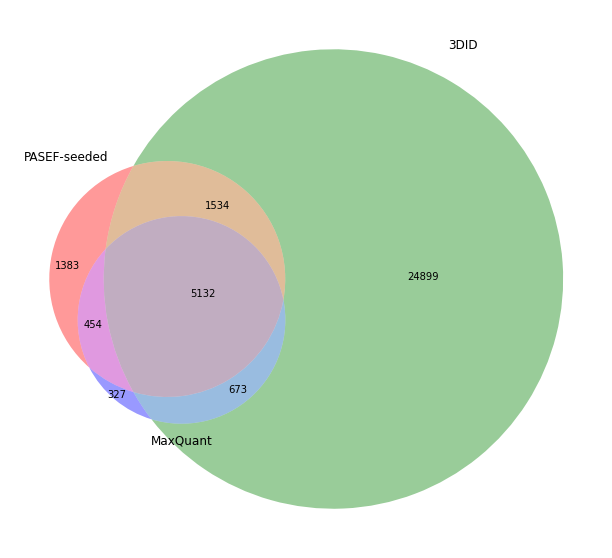

In [42]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

f, ax1 = plt.subplots()
f.set_figheight(10)
f.set_figwidth(15)

plt.margins(0.06)
# plt.title('features identified')

venn3([sets_d['pasef'],sets_d['3did'],sets_d['mq']], ('PASEF-seeded','3DID','MaxQuant'))

plt.show()

In [ ]:
print('3DID found ')

### analyse features that were only identified by the PASEF-seeded method

In [43]:
combined_id_pasef_only = sets_d['pasef']-sets_d['mq']-sets_d['3did']

In [44]:
combined_features_df[(combined_features_df.combined_id.isin(combined_id_pasef_only))].sort_values(by=['pasef_feature_intensity'], ascending=False, inplace=False).head(n=3)

,combined_id,number_of_methods,methods,method_ids,3did_feature_id,pasef_feature_id,mq_feature_id,3did_prediction,3did_deconvolution_score,3did_feature_intensity,pasef_deconvolution_score,pasef_feature_intensity,mq_feature_intensity,3did_log_intensity,pasef_log_intensity,mq_log_intensity
6738,6739,1,[pasef],[pasef-2272901],0,2272901,0,0.790384,246.276535,2723,871.679749,66134.0,0.0,3.435048,4.820425,0.0
6733,6734,1,[pasef],[pasef-3770201],0,3770201,0,0.790384,246.276535,2723,883.855225,61677.0,0.0,3.435048,4.790123,0.0
7306,7307,1,[pasef],[pasef-3893001],0,3893001,0,0.790384,246.276535,2723,510.104919,61035.0,0.0,3.435048,4.785579,0.0


In [45]:
pasef_feature = features_pasef_df[(features_pasef_df.feature_id == 3893001)].iloc[0]
pasef_feature

index                                                                                  89179
mono_mz_lower                                                                    1095.005005
mono_mz_upper                                                                    1095.074829
scan_apex                                                                               95.0
scan_lower                                                                                60
scan_upper                                                                               133
rt_apex                                                                          2114.067139
rt_lower                                                                         2111.420898
rt_upper                                                                         2117.242188
intensity_without_saturation_correction                                                61035
intensity_with_saturation_correction                                  

In [46]:
rt_df = pd.read_json(pasef_feature.rt_df)

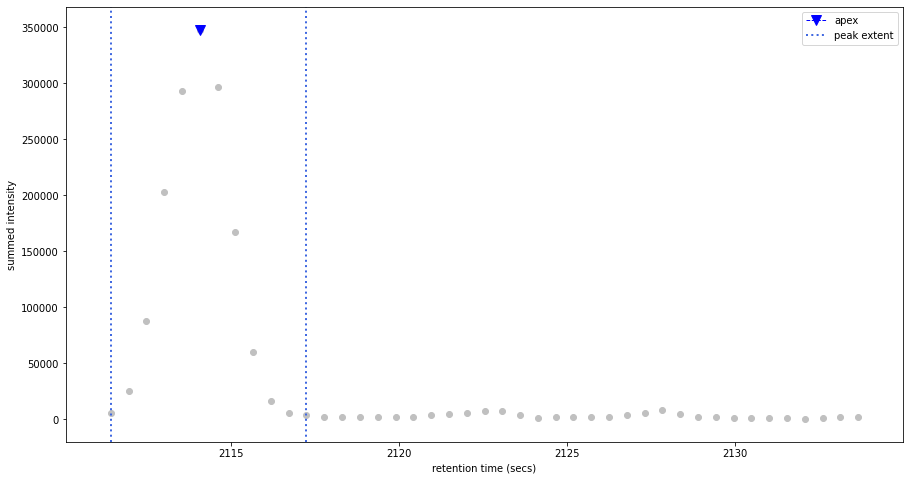

In [47]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

# plot the flattened points
plt.scatter(rt_df.retention_time_secs, rt_df.intensity, c='silver')

plt.plot(pasef_feature.rt_apex, rt_df[rt_df.retention_time_secs.astype(int)==int(pasef_feature.rt_apex)].iloc[0].intensity, marker='v', color='blue', linestyle='--', linewidth=1, ms=10, label='apex')

plt.axvline(x=pasef_feature.rt_lower, linestyle=':', color='royalblue', linewidth=2, label='peak extent')
plt.axvline(x=pasef_feature.rt_upper, linestyle=':', color='royalblue', linewidth=2)

# plt.title('apex in the retention time dimension, feature {}'.format(pasef_feature.feature_id))
plt.legend()
plt.xlabel("retention time (secs)")
plt.ylabel("summed intensity")
plt.show()

#### isotope extent in mobility

In [48]:
scan_df = pd.read_json(pasef_feature.scan_df)

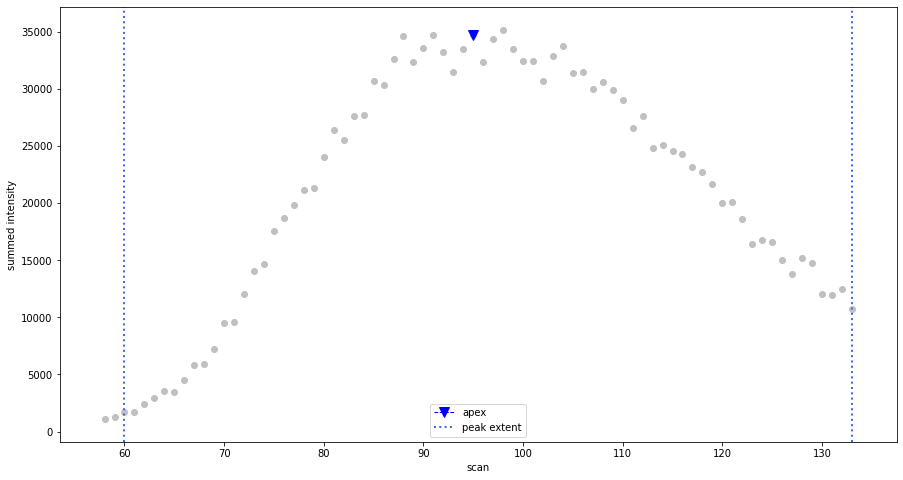

In [49]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

# plot the flattened points
plt.scatter(scan_df.scan, scan_df.intensity, c='silver')

plt.plot(pasef_feature.scan_apex, scan_df[scan_df.scan==pasef_feature.scan_apex].intensity, marker='v', color='blue', linestyle='--', linewidth=1, ms=10, label='apex')

plt.axvline(x=pasef_feature.scan_lower, linestyle=':', color='royalblue', linewidth=2, label='peak extent')
plt.axvline(x=pasef_feature.scan_upper, linestyle=':', color='royalblue', linewidth=2)

# plt.title('apex in the mobility dimension, feature {}'.format(pasef_feature.feature_id))
plt.legend()
plt.xlabel("scan")
plt.ylabel("summed intensity")
plt.show()

#### feature region at its RT apex

In [50]:
feature_mz_lower = json.loads(pasef_feature.envelope)[0][0]
feature_mz_upper = json.loads(pasef_feature.envelope)[-1][0]
feature_scan_lower = pasef_feature.scan_lower
feature_scan_upper = pasef_feature.scan_upper
feature_rt_lower = pasef_feature.rt_apex - 1
feature_rt_upper = pasef_feature.rt_apex + 1

In [51]:
mz_lower = feature_mz_lower - 1
mz_upper = feature_mz_upper + 1
scan_lower = int(feature_scan_lower - 20)
scan_upper = int(feature_scan_upper + 20)
rt_lower = feature_rt_lower
rt_upper = feature_rt_upper

In [52]:
RAW_DATABASE_NAME = '/media/big-ssd/experiments/P3856/raw-databases/P3856_YHE211_1_Slot1-1_1_5104.d'
RAW_HDF_PATH = RAW_DATABASE_NAME.replace('.d','.hdf')

In [53]:
# create the TimsTOF object
if not os.path.isfile(RAW_HDF_PATH):
    print('{} doesn\'t exist so loading the raw data from {}'.format(RAW_HDF_PATH, RAW_DATABASE_NAME))
    data = alphatims.bruker.TimsTOF(RAW_DATABASE_NAME)
    print('saving to {}'.format(RAW_HDF_PATH))
    _ = data.save_as_hdf(
        directory=os.path.split(RAW_HDF_PATH)[0],
        file_name=os.path.split(RAW_HDF_PATH)[1],
        overwrite=True
    )
else:
    print('loading raw data from {}'.format(RAW_HDF_PATH))
    data = alphatims.bruker.TimsTOF(RAW_HDF_PATH)

loading raw data from /media/big-ssd/experiments/P3856/raw-databases/P3856_YHE211_1_Slot1-1_1_5104.hdf


In [54]:
raw_df = data[
    {
        "rt_values": slice(rt_lower, rt_upper),
        "mz_values": slice(mz_lower, mz_upper),
        "scan_indices": slice(scan_lower, scan_upper),
        "precursor_indices": 0,
    }
][['mz_values','scan_indices','frame_indices','rt_values','intensity_values']]
raw_df.rename(columns={'mz_values':'mz', 'scan_indices':'scan', 'frame_indices':'frame_id', 'rt_values':'retention_time_secs', 'intensity_values':'intensity'}, inplace=True)
# downcast the data types to minimise the memory used
int_columns = ['frame_id','scan','intensity']
raw_df[int_columns] = raw_df[int_columns].apply(pd.to_numeric, downcast="unsigned")
float_columns = ['retention_time_secs']
raw_df[float_columns] = raw_df[float_columns].apply(pd.to_numeric, downcast="float")

In [55]:
len(raw_df)

4128

In [56]:
# create the colour map to convert intensity to colour
colour_map = cm.batlow_r
norm = colors.LogNorm(vmin=100, vmax=raw_df.intensity.max(), clip=True)

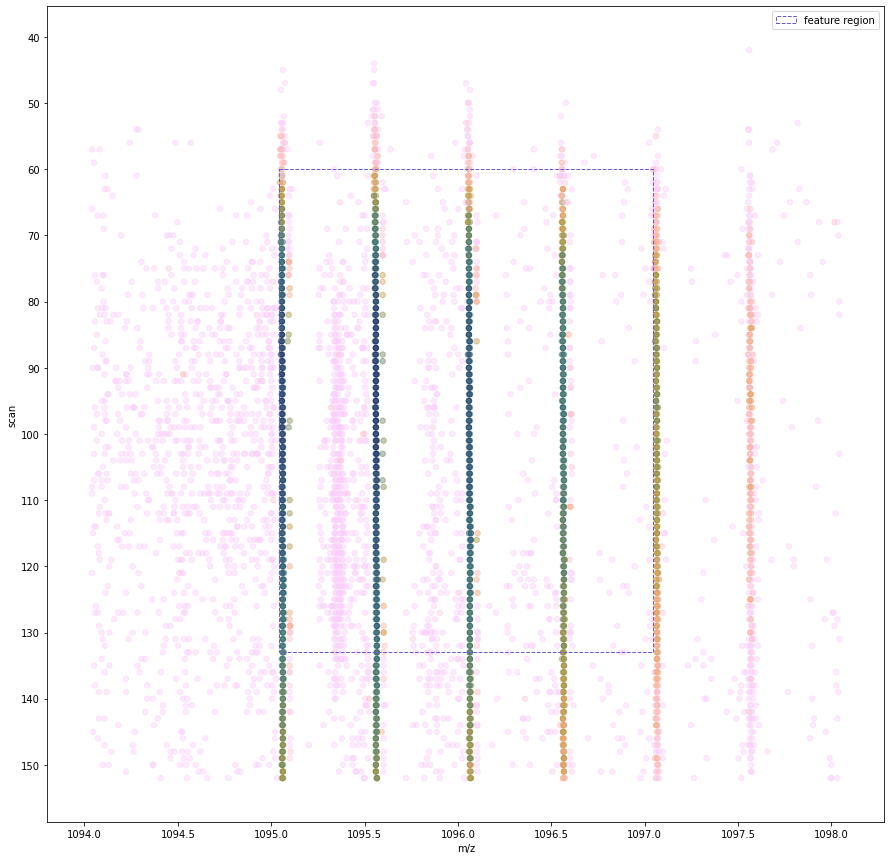

In [57]:
f, ax1 = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)

plt.margins(0.06)

plt.scatter(raw_df.mz, raw_df.scan, c=raw_df.intensity, cmap=colour_map, norm=norm, alpha=0.4, s=30, linewidths=None, edgecolors=None)

# draw the feature region
top_left = (feature_mz_lower,feature_scan_lower)
width = feature_mz_upper - feature_mz_lower
height = feature_scan_upper - feature_scan_lower
cuboid_rect = patches.Rectangle(top_left,width,height,linewidth=1.0,linestyle='--',edgecolor='slateblue',facecolor='none',label='feature region')
ax1.add_patch(cuboid_rect)

plt.xlabel("m/z")
plt.ylabel("scan")

nearest = 0.5
range_l = round(raw_df.mz.min() / nearest) * nearest
range_u = round(raw_df.mz.max() / nearest) * nearest
plt.xticks(np.arange(range_l,range_u+nearest,nearest))

nearest = 10.0
range_l = round(raw_df.scan.min() / nearest) * nearest
range_u = round(raw_df.scan.max() / nearest) * nearest
plt.yticks(np.arange(range_l,range_u+nearest,nearest))

# plt.title('feature region around the voxel\'s midpoint, feature {}, RT {} secs'.format(selected_feature.feature_id, round(selected_feature.voxel_metadata_d['voxel_rt_midpoint'],1)))

plt.legend()
plt.gca().invert_yaxis()
plt.show()

In [58]:
raw_df['normalised_intensity'] = raw_df.intensity / raw_df.intensity.max()

In [59]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Rescale to values between 0 and 1
tableau20_mpl = tableau20.copy()
for i in range(len(tableau20_mpl)):  
    r, g, b = tableau20_mpl[i]  
    tableau20_mpl[i] = (r / 255., g / 255., b / 255.)

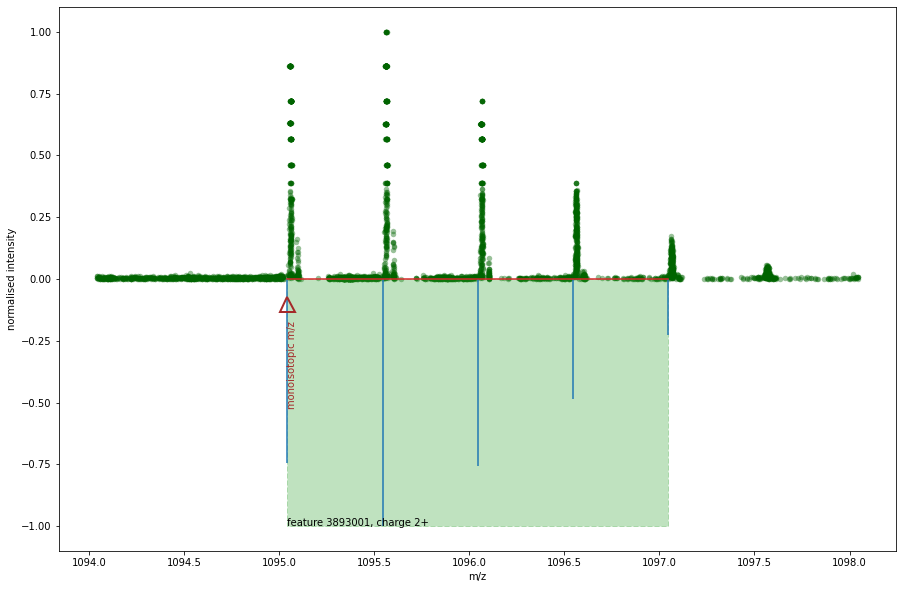

In [60]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(15)

# plot the raw data
ax.scatter(raw_df.mz, raw_df.normalised_intensity, marker='o', color='darkgreen', lw=0, s=30, alpha=0.4)

# plot the feature's bounding rectangle
envelope = json.loads(pasef_feature.envelope)
env_width = envelope[-1][0] - envelope[0][0]
rect_colour = tableau20_mpl[4]
rect = patches.Rectangle((envelope[0][0],0),env_width,-1.0,linewidth=1,linestyle=(0,(5,2)),edgecolor=rect_colour+(0.3,),facecolor=rect_colour+(0.3,),fill=True)
ax.add_patch(rect)
ax.text(x=envelope[0][0], y=-1.0, s='feature {}, charge {}+'.format(pasef_feature.feature_id, pasef_feature.charge))

# determine the peaks from the envelope
envelope_df = pd.DataFrame(envelope, columns=['mz','intensity'])
envelope_df['normalised_intensity'] = envelope_df.intensity / envelope_df.intensity.max()

# plot the peaks from deconvolution
markerline, stemlines, baseline = ax.stem(envelope_df.mz, -envelope_df.normalised_intensity, markerfmt=" ", use_line_collection=True)

# show the monoisotopic m/z determined by deconvolution
ax.plot(pasef_feature.monoisotopic_mz, -0.1, marker='^', markerfacecolor='none', markeredgecolor='brown', linestyle='', markeredgewidth=2, ms=15)
text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
ax.text(pasef_feature.monoisotopic_mz, -0.35, "monoisotopic m/z", **text_style, rotation='vertical')

nearest = 0.5
range_l = round(raw_df.mz.min() / nearest) * nearest
range_u = round(raw_df.mz.max() / nearest) * nearest
ax.set_xticks(np.arange(range_l,range_u+nearest,nearest))

ax.set_xlabel('m/z')
ax.set_ylabel('normalised intensity')

# ax.set_title('spectra for feature {}, monoisotopic peak at {} m/z, charge {}+, deconvolution score: {}'.format(selected_feature.feature_id, round(selected_feature.mono_mz,4), selected_feature.charge, round(selected_feature.deconvolution_score,1)))

plt.show()

### visualise a feature detected by 3DID that crosses a segment boundary

In [61]:
segment_boundary = 820

In [62]:
features_3did_df[(features_3did_df.monoisotopic_mz >= segment_boundary-1) & (features_3did_df.monoisotopic_mz < segment_boundary-0.5)].sort_values(by=['feature_intensity'], ascending=False, inplace=False).head(n=3)

,index,mono_mz_lower,mono_mz_upper,scan_apex,scan_lower,scan_upper,rt_apex,rt_lower,rt_upper,intensity_without_saturation_correction,...,feature_region_3d_extent,voxel_id,voxel_metadata_d,scan_df,scan_r_squared,rt_df,rt_r_squared,feature_id,prediction,identification_predicted
13381,26,819.414368,819.466553,374.0,348.0,400.0,1852.102173,1849.455444,1854.220093,17254,...,"{""mz_lower"": 818.446645, ""mz_upper"": 822.45, ""...",720000091,"{""mz_lower"": 819.4, ""mz_upper"": 819.5, ""scan_l...","[{""scan"":333,""intensity"":238,""filtered_intensi...",0.997026,"[{""frame_id"":16407,""retention_time_secs"":1840....",0.995345,17261,0.841910,True
11747,39,819.434387,819.486572,431.0,407.0,455.0,2111.420898,2106.657959,2117.242188,12746,...,"{""mz_lower"": 818.446645, ""mz_upper"": 822.45, ""...",720000139,"{""mz_lower"": 819.4, ""mz_upper"": 819.5, ""scan_l...","[{""scan"":393,""intensity"":190,""filtered_intensi...",0.991434,"[{""frame_id"":18867,""retention_time_secs"":2100....",0.996980,17274,0.845220,True
13456,52,819.364258,819.416443,322.0,303.0,345.0,1869.039551,1866.393555,1875.918823,11143,...,"{""mz_lower"": 818.346645, ""mz_upper"": 822.35, ""...",720000241,"{""mz_lower"": 819.3000000000001, ""mz_upper"": 81...","[{""scan"":299,""intensity"":72,""filtered_intensit...",0.984936,"[{""frame_id"":16562,""retention_time_secs"":1856....",0.948932,17287,0.841783,True


In [63]:
boundary_3did_feature = features_3did_df.loc[15108]
boundary_3did_feature

index                                                                                   1166
mono_mz_lower                                                                     824.894775
mono_mz_upper                                                                     824.947327
scan_apex                                                                              460.0
scan_lower                                                                             425.0
scan_upper                                                                             485.0
rt_apex                                                                          2098.189453
rt_lower                                                                         2095.543457
rt_upper                                                                         2100.308105
intensity_without_saturation_correction                                                 1402
intensity_with_saturation_correction                                  

#### feature region at its RT apex

In [64]:
feature_mz_lower = json.loads(boundary_3did_feature.envelope)[0][0]
feature_mz_upper = json.loads(boundary_3did_feature.envelope)[-1][0]
feature_scan_lower = boundary_3did_feature.scan_lower
feature_scan_upper = boundary_3did_feature.scan_upper
feature_rt_lower = boundary_3did_feature.rt_apex - 1
feature_rt_upper = boundary_3did_feature.rt_apex + 1

In [65]:
mz_lower = feature_mz_lower - 1
mz_upper = feature_mz_upper + 1
scan_lower = int(feature_scan_lower - 20)
scan_upper = int(feature_scan_upper + 20)
rt_lower = feature_rt_lower
rt_upper = feature_rt_upper

In [66]:
mz_lower,mz_upper

(823.9210320244224, 827.434695165713)

In [67]:
rt_lower,rt_upper

(2097.189453125, 2099.189453125)

In [68]:
scan_lower,scan_upper

(405, 505)

In [69]:
raw_df = data[
    {
        "rt_values": slice(rt_lower, rt_upper),
        "mz_values": slice(mz_lower, mz_upper),
        "scan_indices": slice(scan_lower, scan_upper),
        "precursor_indices": 0,
    }
][['mz_values','scan_indices','frame_indices','rt_values','intensity_values']]
raw_df.rename(columns={'mz_values':'mz', 'scan_indices':'scan', 'frame_indices':'frame_id', 'rt_values':'retention_time_secs', 'intensity_values':'intensity'}, inplace=True)
# downcast the data types to minimise the memory used
int_columns = ['frame_id','scan','intensity']
raw_df[int_columns] = raw_df[int_columns].apply(pd.to_numeric, downcast="unsigned")
float_columns = ['retention_time_secs']
raw_df[float_columns] = raw_df[float_columns].apply(pd.to_numeric, downcast="float")

In [70]:
raw_df

,mz,scan,frame_id,retention_time_secs,intensity
0,824.360492,405,18837,2097.661133,40
1,826.392502,405,18837,2097.661133,26
2,826.419552,405,18837,2097.661133,52
3,826.893004,405,18837,2097.661133,50
4,824.369497,406,18837,2097.661133,84
...,...,...,...,...,...
2523,825.400965,504,18847,2098.718994,111
2524,825.437011,504,18847,2098.718994,20
2525,825.842576,504,18847,2098.718994,99
2526,826.415044,504,18847,2098.718994,22


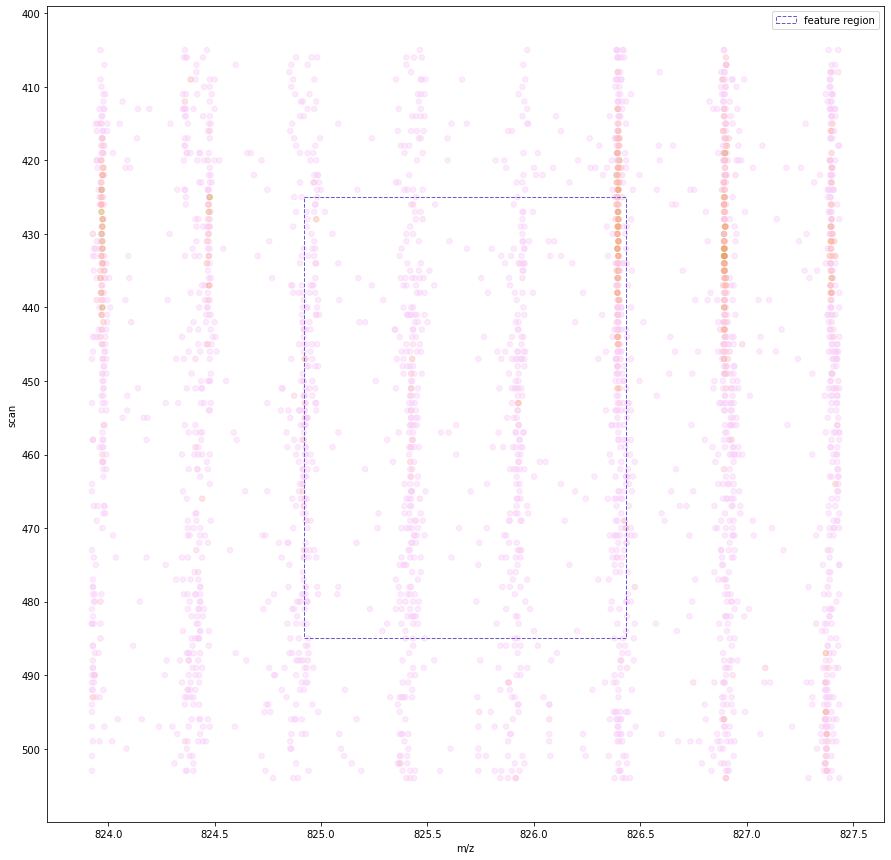

In [71]:
f, ax1 = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)

plt.margins(0.06)

plt.scatter(raw_df.mz, raw_df.scan, c=raw_df.intensity, cmap=colour_map, norm=norm, alpha=0.4, s=30, linewidths=None, edgecolors=None)

# draw the feature region
top_left = (feature_mz_lower,feature_scan_lower)
width = feature_mz_upper - feature_mz_lower
height = feature_scan_upper - feature_scan_lower
cuboid_rect = patches.Rectangle(top_left,width,height,linewidth=1.0,linestyle='--',edgecolor='slateblue',facecolor='none',label='feature region')
ax1.add_patch(cuboid_rect)

plt.xlabel("m/z")
plt.ylabel("scan")

nearest = 0.5
range_l = round(raw_df.mz.min() / nearest) * nearest
range_u = round(raw_df.mz.max() / nearest) * nearest
plt.xticks(np.arange(range_l,range_u+nearest,nearest))

nearest = 10.0
range_l = round(raw_df.scan.min() / nearest) * nearest
range_u = round(raw_df.scan.max() / nearest) * nearest
plt.yticks(np.arange(range_l,range_u+nearest,nearest))

# plt.title('feature region around the voxel\'s midpoint, feature {}, RT {} secs'.format(selected_feature.feature_id, round(selected_feature.voxel_metadata_d['voxel_rt_midpoint'],1)))

plt.legend()
plt.gca().invert_yaxis()
plt.show()

In [72]:
raw_df['normalised_intensity'] = raw_df.intensity / raw_df.intensity.max()

In [73]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Rescale to values between 0 and 1
tableau20_mpl = tableau20.copy()
for i in range(len(tableau20_mpl)):  
    r, g, b = tableau20_mpl[i]  
    tableau20_mpl[i] = (r / 255., g / 255., b / 255.)

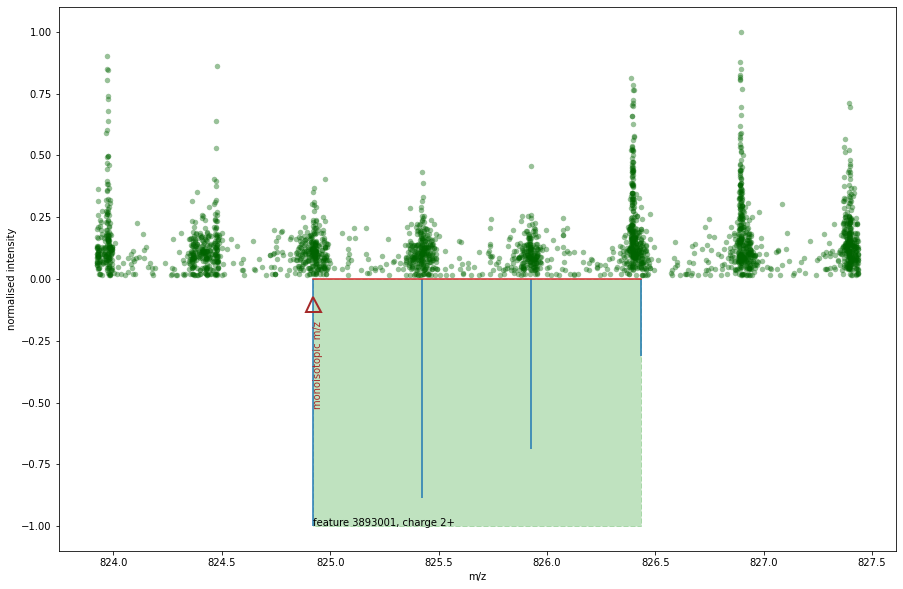

In [74]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(15)

# plot the raw data
ax.scatter(raw_df.mz, raw_df.normalised_intensity, marker='o', color='darkgreen', lw=0, s=30, alpha=0.4)

# plot the feature's bounding rectangle
envelope = json.loads(boundary_3did_feature.envelope)
env_width = envelope[-1][0] - envelope[0][0]
rect_colour = tableau20_mpl[4]
rect = patches.Rectangle((envelope[0][0],0),env_width,-1.0,linewidth=1,linestyle=(0,(5,2)),edgecolor=rect_colour+(0.3,),facecolor=rect_colour+(0.3,),fill=True)
ax.add_patch(rect)
ax.text(x=envelope[0][0], y=-1.0, s='feature {}, charge {}+'.format(pasef_feature.feature_id, pasef_feature.charge))

# determine the peaks from the envelope
envelope_df = pd.DataFrame(envelope, columns=['mz','intensity'])
envelope_df['normalised_intensity'] = envelope_df.intensity / envelope_df.intensity.max()

# plot the peaks from deconvolution
markerline, stemlines, baseline = ax.stem(envelope_df.mz, -envelope_df.normalised_intensity, markerfmt=" ", use_line_collection=True)

# show the monoisotopic m/z determined by deconvolution
ax.plot(boundary_3did_feature.monoisotopic_mz, -0.1, marker='^', markerfacecolor='none', markeredgecolor='brown', linestyle='', markeredgewidth=2, ms=15)
text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
ax.text(boundary_3did_feature.monoisotopic_mz, -0.35, "monoisotopic m/z", **text_style, rotation='vertical')

nearest = 0.5
range_l = round(raw_df.mz.min() / nearest) * nearest
range_u = round(raw_df.mz.max() / nearest) * nearest
ax.set_xticks(np.arange(range_l,range_u+nearest,nearest))

ax.set_xlabel('m/z')
ax.set_ylabel('normalised intensity')

# ax.set_title('spectra for feature {}, monoisotopic peak at {} m/z, charge {}+, deconvolution score: {}'.format(selected_feature.feature_id, round(selected_feature.mono_mz,4), selected_feature.charge, round(selected_feature.deconvolution_score,1)))

plt.show()

### analyse features that were only identified by MaxQuant

In [75]:
combined_id_mq_only = sets_d['mq']-sets_d['3did']-sets_d['pasef']

In [76]:
combined_features_df[(combined_features_df.combined_id.isin(combined_id_mq_only))].sort_values(by=['mq_feature_intensity'], ascending=False, inplace=False).head(n=5)

,combined_id,number_of_methods,methods,method_ids,3did_feature_id,pasef_feature_id,mq_feature_id,3did_prediction,3did_deconvolution_score,3did_feature_intensity,pasef_deconvolution_score,pasef_feature_intensity,mq_feature_intensity,3did_log_intensity,pasef_log_intensity,mq_log_intensity
5263,5264,1,[mq],[mq-1222822],0,0,1222822,0.790384,246.276535,2723,0.0,0.0,1239400.0,3.435048,0.0,6.093211
4114,4115,1,[mq],[mq-1216140],0,0,1216140,0.790384,246.276535,2723,0.0,0.0,472380.0,3.435048,0.0,5.674292
2325,2326,1,[mq],[mq-1202693],0,0,1202693,0.790384,246.276535,2723,0.0,0.0,362510.0,3.435048,0.0,5.559320
3286,3287,1,[mq],[mq-1210092],0,0,1210092,0.790384,246.276535,2723,0.0,0.0,305360.0,3.435048,0.0,5.484812
1455,1456,1,[mq],[mq-1192901],0,0,1192901,0.790384,246.276535,2723,0.0,0.0,276000.0,3.435048,0.0,5.440909


In [77]:
mq_feature = features_mq_df[(features_mq_df.feature_id == 1192901)].iloc[0]
mq_feature

feature_id                                                     1192901
monoisotopic_mass                                            1599.8105
charge                                                               2
monoisotopic_mz                                              800.91254
intensity                                                       276000
scan_apex                                                          408
scan_lower                                                       352.5
scan_upper                                                       463.5
rt_apex                                                         1788.0
rt_lower                                                       1780.32
rt_upper                                                       1795.68
raw_file                                 P3856_YHE211_1_Slot1-1_1_5104
envelope                          [[800.91254, 0.0], [802.91925, 0.0]]
isotope_count                                                        4
mq_ind

#### isotope extent in retention time

In [78]:
mz_lower = mq_feature.monoisotopic_mz-0.1
mz_upper = mq_feature.monoisotopic_mz+0.1
scan_lower = int(mq_feature.scan_lower)
scan_upper = int(mq_feature.scan_upper)
rt_lower = mq_feature.rt_lower
rt_upper = mq_feature.rt_upper

In [79]:
isotope_points_df = data[
    {
        "rt_values": slice(rt_lower, rt_upper),
        "mz_values": slice(mz_lower, mz_upper),
        "scan_indices": slice(scan_lower, scan_upper),
        "precursor_indices": 0,
    }
][['mz_values','scan_indices','frame_indices','rt_values','intensity_values']]
isotope_points_df.rename(columns={'mz_values':'mz', 'scan_indices':'scan', 'frame_indices':'frame_id', 'rt_values':'retention_time_secs', 'intensity_values':'intensity'}, inplace=True)
# downcast the data types to minimise the memory used
int_columns = ['frame_id','scan','intensity']
isotope_points_df[int_columns] = isotope_points_df[int_columns].apply(pd.to_numeric, downcast="unsigned")
float_columns = ['retention_time_secs']
isotope_points_df[float_columns] = isotope_points_df[float_columns].apply(pd.to_numeric, downcast="float")

In [80]:
len(isotope_points_df)

1946

In [81]:
rt_df = isotope_points_df.groupby(['frame_id','retention_time_secs'], as_index=False).intensity.sum()
rt_df.sort_values(by=['retention_time_secs'], ascending=True, inplace=True)

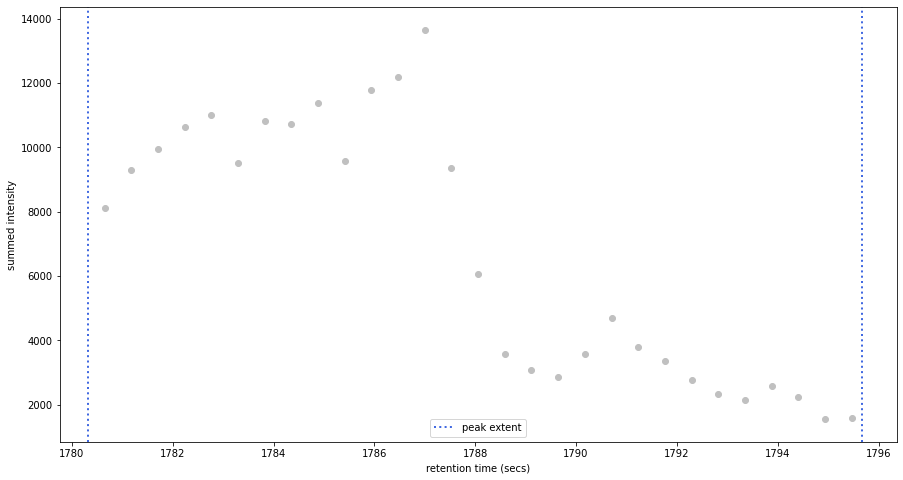

In [82]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

# plot the flattened points
plt.scatter(rt_df.retention_time_secs, rt_df.intensity, c='silver')

# plt.plot(mq_feature.rt_apex, rt_df[rt_df.retention_time_secs.astype(int)==int(mq_feature.rt_apex)].iloc[0].intensity, marker='v', color='blue', linestyle='--', linewidth=1, ms=10, label='apex')

plt.axvline(x=mq_feature.rt_lower, linestyle=':', color='royalblue', linewidth=2, label='peak extent')
plt.axvline(x=mq_feature.rt_upper, linestyle=':', color='royalblue', linewidth=2)

# plt.title('apex in the retention time dimension, feature {}'.format(mq_feature.feature_id))
plt.legend()
plt.xlabel("retention time (secs)")
plt.ylabel("summed intensity")
plt.show()

#### isotope extent in mobility

In [83]:
scan_df = isotope_points_df.groupby(['scan'], as_index=False).intensity.sum()
scan_df.sort_values(by=['scan'], ascending=True, inplace=True)

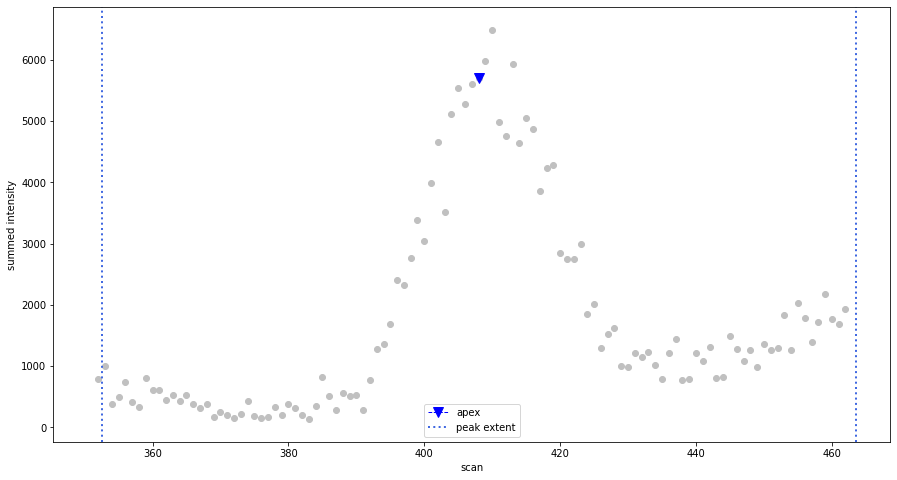

In [84]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

# plot the flattened points
plt.scatter(scan_df.scan, scan_df.intensity, c='silver')

plt.plot(mq_feature.scan_apex, scan_df[scan_df.scan==mq_feature.scan_apex].intensity, marker='v', color='blue', linestyle='--', linewidth=1, ms=10, label='apex')

plt.axvline(x=mq_feature.scan_lower, linestyle=':', color='royalblue', linewidth=2, label='peak extent')
plt.axvline(x=mq_feature.scan_upper, linestyle=':', color='royalblue', linewidth=2)

# plt.title('apex in the mobility dimension, feature {}'.format(mq_feature.feature_id))
plt.legend()
plt.xlabel("scan")
plt.ylabel("summed intensity")
plt.show()

#### feature region at its RT apex

In [85]:
# create the colour map to convert intensity to colour
colour_map = cm.batlow_r
norm = colors.LogNorm(vmin=100, vmax=1000, clip=True)

In [86]:
feature_mz_lower = json.loads(mq_feature.envelope)[0][0]
feature_mz_upper = json.loads(mq_feature.envelope)[-1][0]
feature_scan_lower = mq_feature.scan_lower
feature_scan_upper = mq_feature.scan_upper
feature_rt_lower = mq_feature.rt_apex - 1
feature_rt_upper = mq_feature.rt_apex + 1

In [87]:
mz_lower = feature_mz_lower - 1
mz_upper = feature_mz_upper + 1
scan_lower = int(feature_scan_lower - 20)
scan_upper = int(feature_scan_upper + 20)
rt_lower = feature_rt_lower
rt_upper = feature_rt_upper

In [88]:
raw_df = data[
    {
        "rt_values": slice(rt_lower, rt_upper),
        "mz_values": slice(mz_lower, mz_upper),
        "scan_indices": slice(scan_lower, scan_upper),
        "precursor_indices": 0,
    }
][['mz_values','scan_indices','frame_indices','rt_values','intensity_values']]
raw_df.rename(columns={'mz_values':'mz', 'scan_indices':'scan', 'frame_indices':'frame_id', 'rt_values':'retention_time_secs', 'intensity_values':'intensity'}, inplace=True)
# downcast the data types to minimise the memory used
int_columns = ['frame_id','scan','intensity']
raw_df[int_columns] = raw_df[int_columns].apply(pd.to_numeric, downcast="unsigned")
float_columns = ['retention_time_secs']
raw_df[float_columns] = raw_df[float_columns].apply(pd.to_numeric, downcast="float")

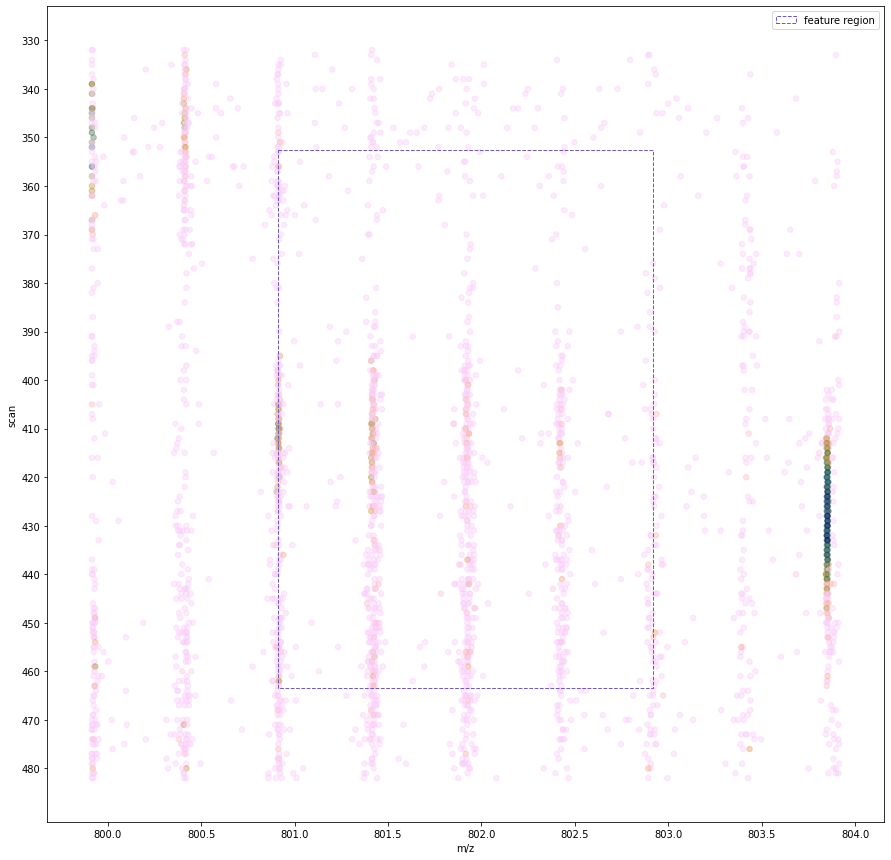

In [89]:
f, ax1 = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)

plt.margins(0.06)

plt.scatter(raw_df.mz, raw_df.scan, c=raw_df.intensity, cmap=colour_map, norm=norm, alpha=0.4, s=30, linewidths=None, edgecolors=None)

# draw the feature region
top_left = (feature_mz_lower,feature_scan_lower)
width = feature_mz_upper - feature_mz_lower
height = feature_scan_upper - feature_scan_lower
cuboid_rect = patches.Rectangle(top_left,width,height,linewidth=1.0,linestyle='--',edgecolor='slateblue',facecolor='none',label='feature region')
ax1.add_patch(cuboid_rect)

plt.xlabel("m/z")
plt.ylabel("scan")

nearest = 0.5
range_l = round(raw_df.mz.min() / nearest) * nearest
range_u = round(raw_df.mz.max() / nearest) * nearest
plt.xticks(np.arange(range_l,range_u+nearest,nearest))

nearest = 10.0
range_l = round(raw_df.scan.min() / nearest) * nearest
range_u = round(raw_df.scan.max() / nearest) * nearest
plt.yticks(np.arange(range_l,range_u+nearest,nearest))

# plt.title('feature region around the voxel\'s midpoint, feature {}, RT {} secs'.format(selected_feature.feature_id, round(selected_feature.voxel_metadata_d['voxel_rt_midpoint'],1)))

plt.legend()
plt.gca().invert_yaxis()
plt.show()

In [90]:
raw_df['normalised_intensity'] = raw_df.intensity / raw_df.intensity.max()

In [91]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Rescale to values between 0 and 1
tableau20_mpl = tableau20.copy()
for i in range(len(tableau20_mpl)):  
    r, g, b = tableau20_mpl[i]  
    tableau20_mpl[i] = (r / 255., g / 255., b / 255.)

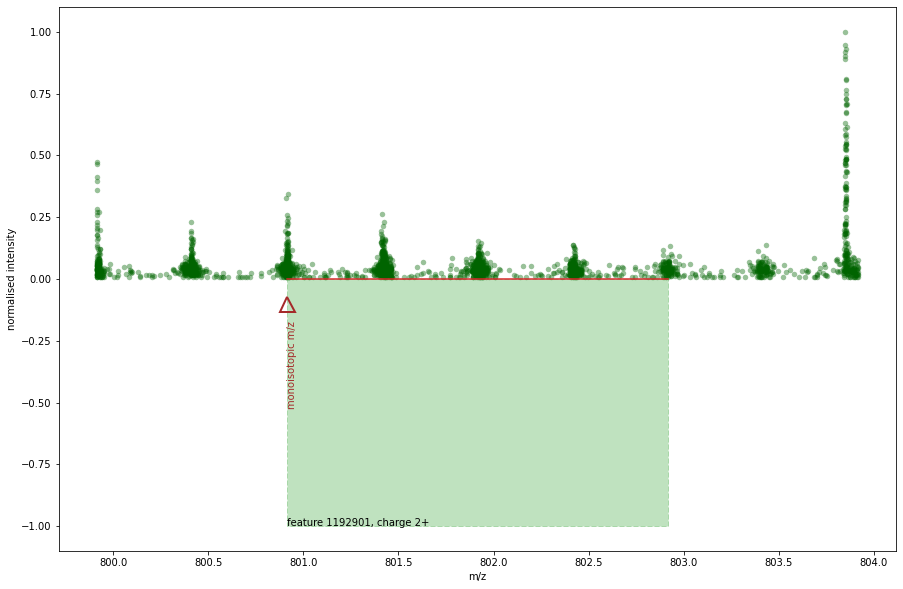

In [92]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(15)

# plot the raw data
ax.scatter(raw_df.mz, raw_df.normalised_intensity, marker='o', color='darkgreen', lw=0, s=30, alpha=0.4)

# plot the feature's bounding rectangle
envelope = json.loads(mq_feature.envelope)
env_width = envelope[-1][0] - envelope[0][0]
rect_colour = tableau20_mpl[4]
rect = patches.Rectangle((envelope[0][0],0),env_width,-1.0,linewidth=1,linestyle=(0,(5,2)),edgecolor=rect_colour+(0.3,),facecolor=rect_colour+(0.3,),fill=True)
ax.add_patch(rect)
ax.text(x=envelope[0][0], y=-1.0, s='feature {}, charge {}+'.format(mq_feature.feature_id, mq_feature.charge))

# determine the peaks from the envelope
envelope_df = pd.DataFrame(envelope, columns=['mz','intensity'])
envelope_df['normalised_intensity'] = envelope_df.intensity / envelope_df.intensity.max()

# plot the peaks from deconvolution
markerline, stemlines, baseline = ax.stem(envelope_df.mz, -envelope_df.normalised_intensity, markerfmt=" ", use_line_collection=True)

# show the monoisotopic m/z determined by deconvolution
ax.plot(mq_feature.monoisotopic_mz, -0.1, marker='^', markerfacecolor='none', markeredgecolor='brown', linestyle='', markeredgewidth=2, ms=15)
text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
ax.text(mq_feature.monoisotopic_mz, -0.35, "monoisotopic m/z", **text_style, rotation='vertical')

nearest = 0.5
range_l = round(raw_df.mz.min() / nearest) * nearest
range_u = round(raw_df.mz.max() / nearest) * nearest
ax.set_xticks(np.arange(range_l,range_u+nearest,nearest))

ax.set_xlabel('m/z')
ax.set_ylabel('normalised intensity')

# ax.set_title('spectra for feature {}, monoisotopic peak at {} m/z, charge {}+, deconvolution score: {}'.format(selected_feature.feature_id, round(selected_feature.mono_mz,4), selected_feature.charge, round(selected_feature.deconvolution_score,1)))

plt.show()

### analyse other attributes of features in common

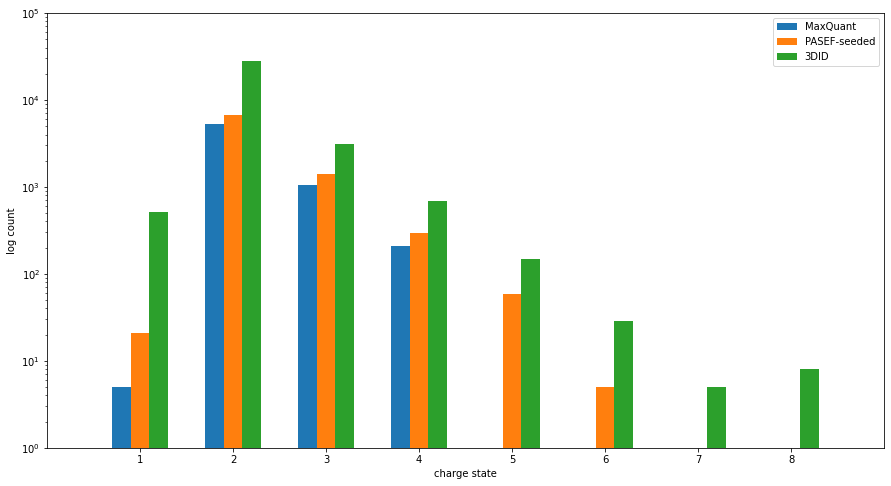

In [93]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

barwidth = 0.2
max_charge = max(idents_mq_df.charge.max(), idents_pasef_df.charge.max(), features_3did_df.charge.max())

pos1 = [x - barwidth for x in range(max_charge+1)]
pos2 = [x + barwidth for x in pos1]
pos3 = [x + (2*barwidth) for x in pos1]

counts = np.bincount(idents_mq_df.charge, minlength=max_charge+1)
ax1.bar(pos1, counts, width=barwidth, align='center', log=True, label='MaxQuant')

counts = np.bincount(idents_pasef_df.charge, minlength=max_charge+1)
ax1.bar(pos2, counts, width=barwidth, align='center', log=True, label='PASEF-seeded')

counts = np.bincount(features_3did_df.charge, minlength=max_charge+1)
ax1.bar(pos3, counts, width=barwidth, align='center', log=True, label='3DID')

ax1.set(xticks=range(1,max_charge+1), xlim=[0, max_charge+1])

plt.xlabel('charge state')
plt.ylabel('log count')
# plt.title('distribution of charge states for identified features\nrun {}, experiment {}'.format(run_name, experiment_name))

plt.ylim((1,10**5))

plt.legend()
plt.show()

In [94]:
pasef_3did_df = combined_features_df[(combined_features_df.pasef_feature_id > 0) & (combined_features_df['3did_feature_id'] > 0)]

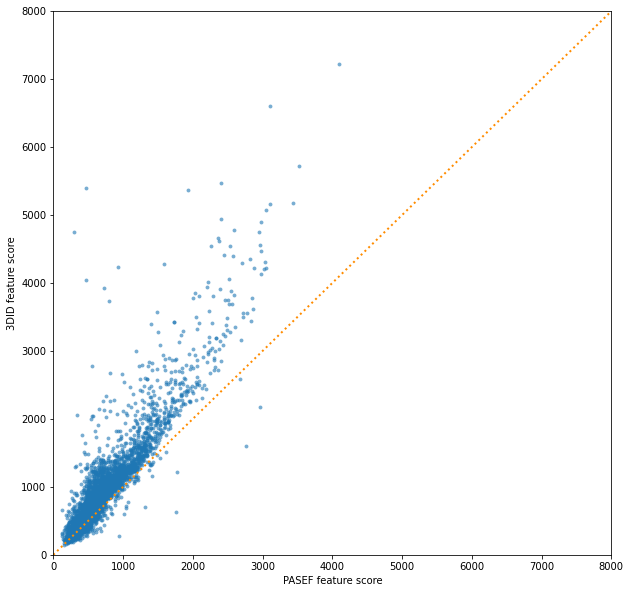

In [95]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(10)

plt.margins(0.06)
# plt.title('deconvolution score for features identified by PASEF-seeded and features detected by 3DID methods')

ax.scatter(pasef_3did_df.pasef_deconvolution_score, pasef_3did_df['3did_deconvolution_score'], marker='o', lw=0, s=15, alpha=0.6)

ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle=':', linewidth=2, color='darkorange')

plt.xlim((-1,8000))
plt.ylim((-1,8000))

plt.xlabel('PASEF feature score')
plt.ylabel('3DID feature score')

plt.show()

In [96]:
combined_features_df = pd.read_feather('{}/combined_idents_df.feather'.format(expanduser('~')))

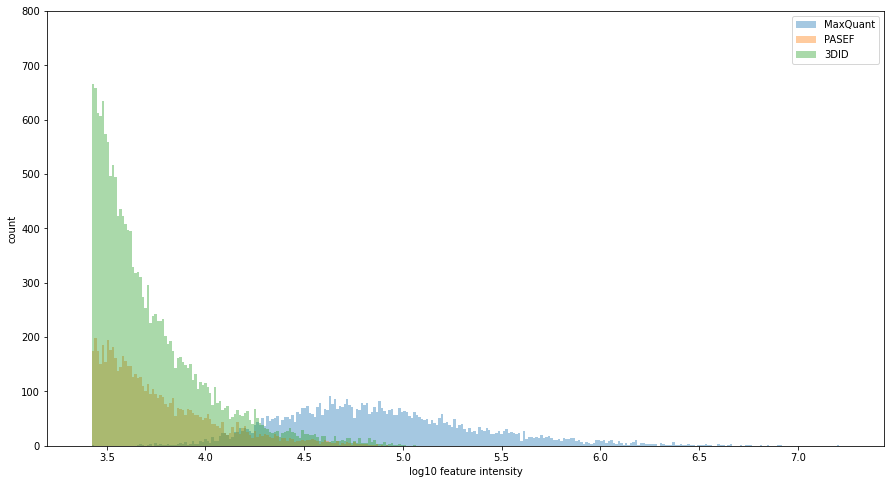

In [97]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
# plt.title('intensity distribution')

bins = 300
hist, bins, _ = plt.hist(combined_features_df[combined_features_df.mq_feature_id > 0].mq_log_intensity, bins=bins, alpha=0.4, label='MaxQuant')
hist, bins, _ = plt.hist(combined_features_df[combined_features_df.pasef_feature_id > 0].pasef_log_intensity, bins=bins, alpha=0.4, label='PASEF')
hist, bins, _ = plt.hist(combined_features_df[combined_features_df['3did_feature_id'] > 0]['3did_log_intensity'], bins=bins, alpha=0.4, label='3DID')

plt.xlabel('log10 feature intensity')
plt.ylabel('count')

# plt.xlim((0,8))
plt.ylim((0,800))

plt.legend()
plt.show()

In [98]:
unique_mq_df = combined_features_df[(combined_features_df.mq_feature_id > 0) & (combined_features_df.pasef_feature_id == 0) & (combined_features_df['3did_feature_id'] == 0)]
unique_pasef_df = combined_features_df[(combined_features_df.mq_feature_id == 0) & (combined_features_df.pasef_feature_id > 0) & (combined_features_df['3did_feature_id'] == 0)]
unique_3did_df = combined_features_df[(combined_features_df.mq_feature_id == 0) & (combined_features_df.pasef_feature_id == 0) & (combined_features_df['3did_feature_id'] > 0)]

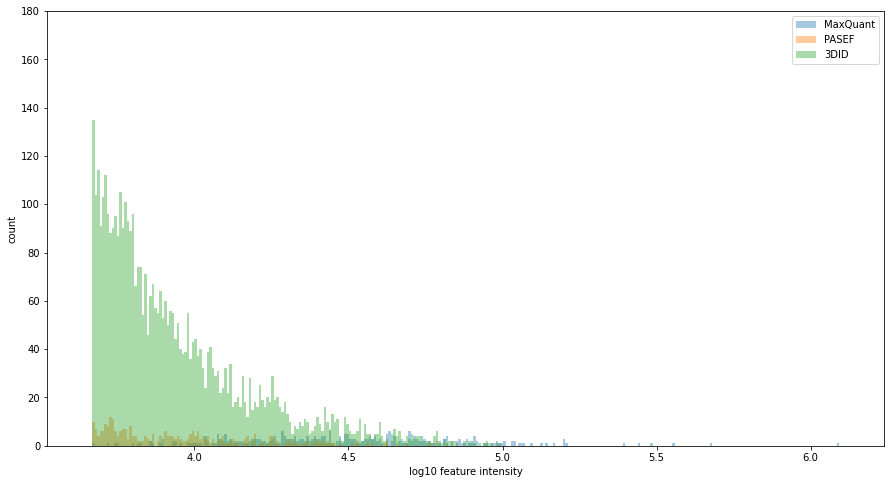

In [99]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
# plt.title('intensity distribution (unique identifications)')

bins = 300
hist, bins, _ = plt.hist(unique_mq_df.mq_log_intensity, bins=bins, alpha=0.4, label='MaxQuant')
hist, bins, _ = plt.hist(unique_pasef_df.pasef_log_intensity, bins=bins, alpha=0.4, label='PASEF')
hist, bins, _ = plt.hist(unique_3did_df['3did_log_intensity'], bins=bins, alpha=0.4, label='3DID')

plt.xlabel('log10 feature intensity')
plt.ylabel('count')

# plt.xlim((0,8))
plt.ylim((0,180))

plt.legend()
plt.show()

### distribution of MaxQuant identified features also identified by 3DID

In [100]:
all_mq_df = combined_features_df[(combined_features_df.mq_feature_id > 0)]
all_mq_common_3did_df = combined_features_df[(combined_features_df.mq_feature_id > 0) & (combined_features_df['3did_feature_id'] > 0)]

In [101]:
print('3DID identified {}% of the features identified by MaxQuant'.format(round(len(all_mq_common_3did_df) / len(all_mq_df) * 100)))

3DID identified 88% of the features identified by MaxQuant


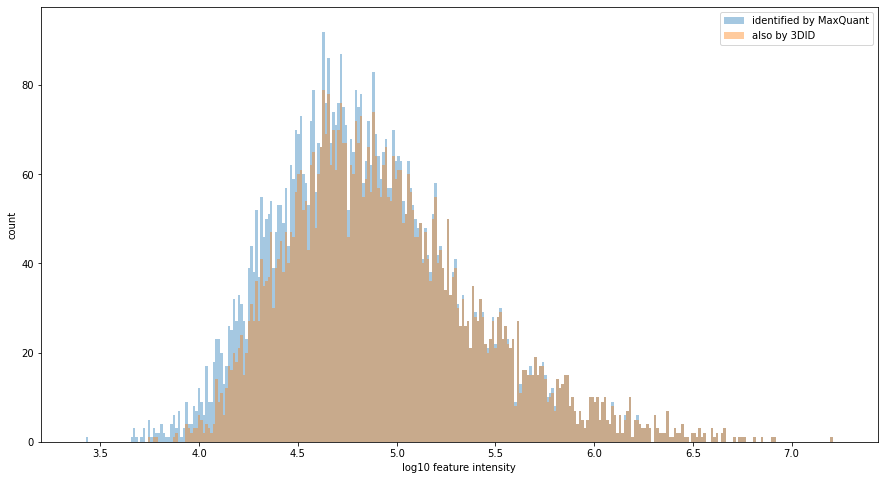

In [102]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
# plt.title('intensity distribution of features identified by MaxQuant also detected by 3DID')

bins = 300
hist, bins, _ = plt.hist(all_mq_df.mq_log_intensity, bins=bins, alpha=0.4, label='identified by MaxQuant')
hist, bins, _ = plt.hist(all_mq_common_3did_df.mq_log_intensity, bins=bins, alpha=0.4, label='also by 3DID')

plt.xlabel('log10 feature intensity')
plt.ylabel('count')

# plt.xlim((0,8))
# plt.ylim((0,800))

plt.legend()
plt.show()

#### is there a linear scaling factor between 3DID and MaxQuant intensity?

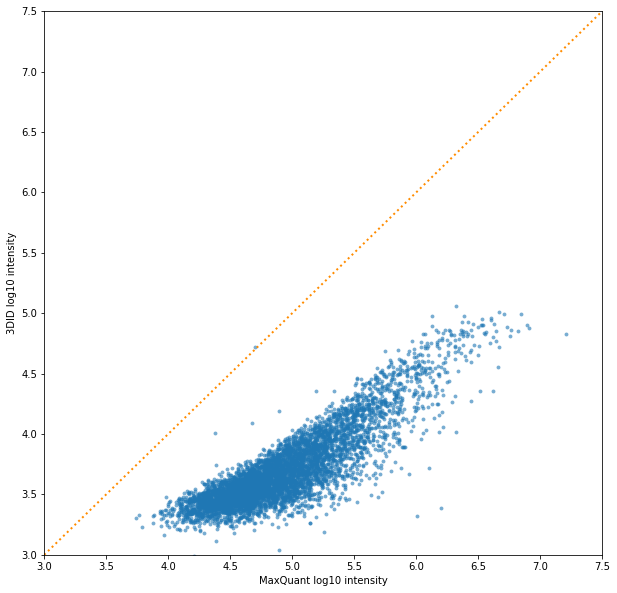

In [103]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(10)

plt.margins(0.06)
# plt.title('intensity of features in common between MaxQuant and 3DID')

ax.scatter(all_mq_common_3did_df.mq_log_intensity, all_mq_common_3did_df['3did_log_intensity'], marker='o', lw=0, s=15, alpha=0.6)

ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle=':', linewidth=2, color='darkorange')

plt.xlim((3.0,7.5))
plt.ylim((3.0,7.5))

plt.xlabel('MaxQuant log10 intensity')
plt.ylabel('3DID log10 intensity')

plt.show()

### compare 3did _identified_ features for different minvi

In [104]:
MINVI_LOW = 3000
MINVI_HIGH = 5000

In [105]:
FEATURES_3DID_MINVI_LOW_DIR = sorted(glob.glob('/media/big-ssd/results-P3856-3did/minvi-{}-*/features-3did'.format(MINVI_LOW)))[-1]
FEATURES_3DID_MINVI_LOW_FILE = '{}/exp-{}-run-{}-features-3did-dedup.feather'.format(FEATURES_3DID_MINVI_LOW_DIR, experiment_name, run_name)

FEATURES_3DID_MINVI_HIGH_DIR = sorted(glob.glob('/media/big-ssd/results-P3856-3did/minvi-{}-*/features-3did'.format(MINVI_HIGH)))[-1]
FEATURES_3DID_MINVI_HIGH_FILE = '{}/exp-{}-run-{}-features-3did-dedup.feather'.format(FEATURES_3DID_MINVI_HIGH_DIR, experiment_name, run_name)

In [106]:
FEATURES_3DID_MINVI_HIGH_FILE

'/media/big-ssd/results-P3856-3did/minvi-5000-2021-09-11-15-03-24/features-3did/exp-P3856-run-P3856_YHE211_1_Slot1-1_1_5104-features-3did-dedup.feather'

In [107]:
FEATURES_3DID_MINVI_LOW_FILE

'/media/big-ssd/results-P3856-3did/minvi-3000-2021-09-11-10-49-01/features-3did/exp-P3856-run-P3856_YHE211_1_Slot1-1_1_5104-features-3did-dedup.feather'

In [108]:
# load the features detected by 3DID
minvi_high_idents_df = pd.read_feather(FEATURES_3DID_MINVI_HIGH_FILE)

In [109]:
# load the features detected by 3DID
minvi_low_idents_df = pd.read_feather(FEATURES_3DID_MINVI_LOW_FILE)

In [110]:
minvi_high_idents_df = minvi_high_idents_df[combined_names].copy()
minvi_high_idents_df['minvi'] = str(MINVI_HIGH)

minvi_low_idents_df = minvi_low_idents_df[combined_names].copy()
minvi_low_idents_df['minvi'] = str(MINVI_LOW)

minvi_idents_df = pd.concat([minvi_low_idents_df,minvi_high_idents_df], axis=0, sort=False, ignore_index=True)
minvi_idents_df['minvi_feature_id'] = minvi_idents_df.minvi+'-'+minvi_idents_df.feature_id.astype('str')

In [111]:
len(minvi_high_idents_df), len(minvi_low_idents_df)

(32333, 51402)

In [112]:
minvi_idents_df.sample(n=5)

,feature_id,charge,monoisotopic_mz,scan_apex,rt_apex,minvi,minvi_feature_id
82458,53450,2,1088.083130,144.0,1973.824463,5000,5000-53450
47857,10553,2,681.350159,706.0,2006.106323,3000,3000-10553
52026,58681,3,1187.610718,359.0,2189.221191,5000,5000-58681
76095,13611,2,771.331055,588.0,1659.971802,5000,5000-13611
32081,126444,2,1120.082886,113.0,2069.606689,3000,3000-126444


#### find the identifications in common between the different minvi values

In [113]:
# set up dup definitions
MZ_TOLERANCE_PERCENT = DUP_MZ_TOLERANCE_PPM * 10**-4
minvi_idents_df['dup_mz'] = minvi_idents_df['monoisotopic_mz']  # shorthand to reduce verbosity
minvi_idents_df['dup_mz_ppm_tolerance'] = minvi_idents_df.dup_mz * MZ_TOLERANCE_PERCENT / 100
minvi_idents_df['dup_mz_lower'] = minvi_idents_df.dup_mz - minvi_idents_df.dup_mz_ppm_tolerance
minvi_idents_df['dup_mz_upper'] = minvi_idents_df.dup_mz + minvi_idents_df.dup_mz_ppm_tolerance
minvi_idents_df['dup_scan_lower'] = minvi_idents_df.scan_apex - DUP_SCAN_TOLERANCE
minvi_idents_df['dup_scan_upper'] = minvi_idents_df.scan_apex + DUP_SCAN_TOLERANCE
minvi_idents_df['dup_rt_lower'] = minvi_idents_df.rt_apex - DUP_RT_TOLERANCE
minvi_idents_df['dup_rt_upper'] = minvi_idents_df.rt_apex + DUP_RT_TOLERANCE

In [114]:
combined_id = 1
combined_features = []
sets_minvi_d = {str(MINVI_HIGH):set(), str(MINVI_LOW):set()}
features_processed = set()
for row in minvi_idents_df.itertuples():
    if row.minvi_feature_id not in features_processed:
        df = minvi_idents_df[(row.charge == minvi_idents_df.charge) & (row.dup_mz >= minvi_idents_df.dup_mz_lower) & (row.dup_mz <= minvi_idents_df.dup_mz_upper) & (row.scan_apex >= minvi_idents_df.dup_scan_lower) & (row.scan_apex <= minvi_idents_df.dup_scan_upper) & (row.rt_apex >= minvi_idents_df.dup_rt_lower) & (row.rt_apex <= minvi_idents_df.dup_rt_upper)].copy()
        if len(df) > 0:
            # remove the features that have already been processed
            feature_ids_not_processed = set(df.minvi_feature_id.tolist()) - features_processed
            df = df[(df.minvi_feature_id.isin(feature_ids_not_processed))]
            for minvi in df.minvi.tolist():
                sets_minvi_d[minvi].add(combined_id)
            # record the features that have been processed
            features_processed.update(set(df.minvi_feature_id.tolist()))
            # separate the minvi feature ids
            feature_ids = {str(MINVI_HIGH):0, str(MINVI_LOW):0}
            for m in df.minvi_feature_id.tolist():
                minvi = m.split('-')[0]
                feature_id = int(m.split('-')[1])
                feature_ids[minvi] = feature_id
            # store the features that were combined
            combined_features.append({'combined_id':combined_id, 'number_of_minvis':len(df.minvi.unique()), 'minvis':list(df.minvi.unique()), 'minvi_ids':df.minvi_feature_id.tolist(), 'minvi_5000_feature_id':feature_ids['5000'], 'minvi_3000_feature_id':feature_ids['3000']})
            # update the combined feature identifier
            combined_id += 1

In [115]:
combined_features_minvi_df = pd.DataFrame(combined_features)
combined_features_minvi_df.to_feather('{}/combined_features_minvi_df.feather'.format(expanduser('~')))

In [116]:
combined_features_minvi_df.sample(n=5)

,combined_id,number_of_minvis,minvis,minvi_ids,minvi_5000_feature_id,minvi_3000_feature_id
21662,21663,2,"[3000, 5000]","[3000-91391, 5000-39578]",39578,91391
4496,4497,2,"[3000, 5000]","[3000-53451, 5000-23053]",23053,53451
10974,10975,2,"[3000, 5000]","[3000-60512, 5000-26422]",26422,60512
17137,17138,2,"[3000, 5000]","[3000-93764, 5000-40912]",40912,93764
6766,6767,2,"[3000, 5000]","[3000-110658, 5000-48228]",48228,110658


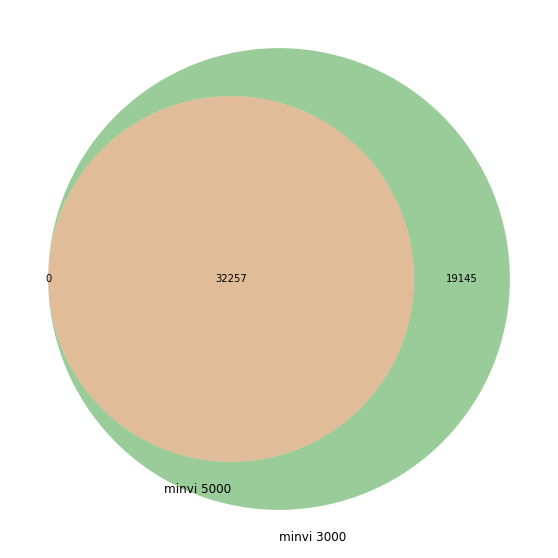

In [117]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

f, ax1 = plt.subplots()
f.set_figheight(10)
f.set_figwidth(15)

plt.margins(0.06)
# plt.title('features identified with minvi={} and minvi={}'.format(MINVI_LOW,MINVI_HIGH))

venn2([sets_minvi_d[str(MINVI_HIGH)],sets_minvi_d[str(MINVI_LOW)]], ('minvi {}'.format(MINVI_HIGH),'minvi {}'.format(MINVI_LOW)))

plt.show()